In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from io import BytesIO
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from sklearn.utils import shuffle

In [3]:
# -----------------------------
# Direktori Dataset
BASE_DIR = r'C:\Users\ASUS\Documents\ML CNN (Bangkit)'  # Sesuaikan path dengan lokasi sebenarnya
DATA_DIR = os.path.join(BASE_DIR, 'dataset', 'downSyndrome')

# Subdirectories
DOWN_SYNDROME_DIR = os.path.join(DATA_DIR, 'downSyndrome')
HEALTHY_DIR = os.path.join(DATA_DIR, 'healty')

# Cek jumlah gambar per kelas
print(f"There are {len(os.listdir(DOWN_SYNDROME_DIR))} images of Down Syndrome.")
print(f"There are {len(os.listdir(HEALTHY_DIR))} images of Healthy.")


There are 1500 images of Down Syndrome.
There are 1499 images of Healthy.


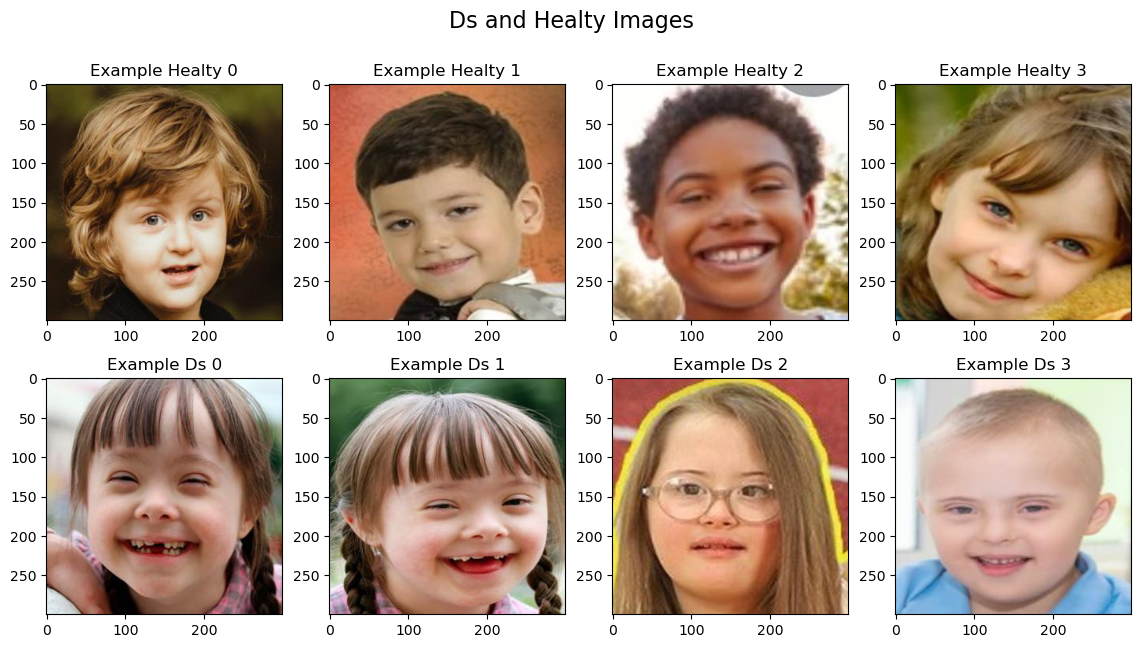

In [9]:
# Get the filenames for cats and dogs images
ds_filenames = [os.path.join(DOWN_SYNDROME_DIR, filename) for filename in os.listdir(DOWN_SYNDROME_DIR)]
healty_filenames = [os.path.join(HEALTHY_DIR, filename) for filename in os.listdir(HEALTHY_DIR)]

fig, axes = plt.subplots(2, 4, figsize=(14, 7))
fig.suptitle('Ds and Healty Images', fontsize=16)

# Plot the first 4 images of each class
for i, healty_image in enumerate(healty_filenames[:4]):
    img = tf.keras.utils.load_img(healty_image)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Example Healty {i}')

for i, ds_image in enumerate(ds_filenames[:4]):
    img = tf.keras.utils.load_img(ds_image)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f'Example Ds {i}')

plt.show()

In [25]:
def train_val_datasets():
    #load the training dataset
    training_dataset = tf.keras.utils.image_dataset_from_directory(
        # Updated directory path to reflect the correct location in Google Drive
        directory= os.path.join(BASE_DIR, 'dataset', 'downSyndrome'),  
        image_size=(256, 256),
        batch_size=128,
        label_mode="binary",
        validation_split=0.15,
        subset="training",
        seed=42
    )

    # Load the validation dataset
    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        # Updated directory path to reflect the correct location in Google Drive
        directory= os.path.join(BASE_DIR, 'dataset', 'downSyndrome'), 
        image_size=(256, 256),
        batch_size=128,
        label_mode="binary",
        validation_split=0.15,
        subset="validation",
        seed=42
    )

    return training_dataset, validation_dataset

In [27]:
# Create the datasets
training_dataset, validation_dataset = train_val_datasets()

Found 2999 files belonging to 2 classes.
Using 2550 files for training.
Found 2999 files belonging to 2 classes.
Using 449 files for validation.


In [29]:
# Get the first batch of images and labels
for images, labels in training_dataset.take(1):
	example_batch_images = images
	example_batch_labels = labels

print(f"Maximum pixel value of images: {np.max(example_batch_images)}\n")
print(f"Shape of batch of images: {example_batch_images.shape}")
print(f"Shape of batch of labels: {example_batch_labels.shape}")

Maximum pixel value of images: 255.0

Shape of batch of images: (128, 256, 256, 3)
Shape of batch of labels: (128, 1)


In [31]:
#create_augmentation_model
def create_augmentation_model():
    augmentation_model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),  # Define input shape
        tf.keras.layers.RandomFlip("horizontal"),    # Randomly flip images horizontally
        tf.keras.layers.RandomRotation(0.1),         # Random rotation within 10%
        tf.keras.layers.RandomTranslation(0.1, 0.1), # Random translation in width and height
        tf.keras.layers.RandomZoom(0.1),             # Random zoom in and out
        tf.keras.layers.RandomContrast(0.2),         # Random contrast
        tf.keras.layers.RandomBrightness(0.2)        # Random brightness
    ])

    return augmentation_model

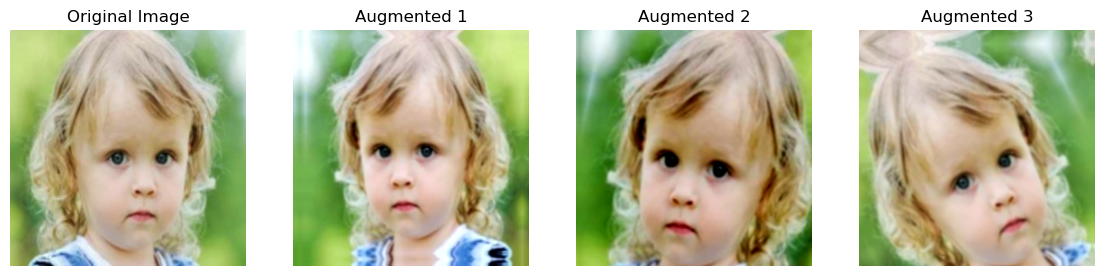

In [33]:
# Load your model for augmentation
data_augmentor = create_augmentation_model()

# Take a sample image
sample_image = tf.keras.utils.array_to_img(example_batch_images[0])

images = [sample_image]

# Apply random augmentation 3 times
for _ in range(3):
	image_aug = data_augmentor(tf.expand_dims(sample_image, axis=0))
	image_aug = tf.keras.utils.array_to_img(tf.squeeze(image_aug))
	images.append(image_aug)


fig, axs = plt.subplots(1, 4, figsize=(14, 7))
for ax, image, title in zip(axs, images, ['Original Image', 'Augmented 1', 'Augmented 2', 'Augmented 3']):
    ax.imshow(image, cmap='gray')
    ax.set_title(title)
    ax.axis('off')

plt.show()

In [35]:
# create_model

def create_model():

	# Get the augmentation layers (or model) from your earlier function
    augmentation_layers = create_augmentation_model()

	# Don't forget to add the augmentation layers! These usually go right after the Input!
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)),   # Define input shape
        augmentation_layers,                          # Add augmentation layers
        tf.keras.layers.Rescaling(1./255),            # Rescale pixel values

        # First Convolutional Block
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Second Convolutional Block
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        # Third Convolutional Block
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),

        #four con
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.5),

        tf.keras.layers.Flatten(),                   # Flatten the features
        tf.keras.layers.Dense(128, activation='relu'), # Fully connected layer
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid') # Output layer for binary classification
    ])


    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


    return model

In [37]:
# Create the compiled but untrained model
model = create_model()

In [39]:
# Remember to inherit from the correct class
class EarlyStoppingCallback(tf.keras.callbacks.Callback):

    # Define the correct function signature for on_epoch_end method
    def on_epoch_end(self, epoch, logs=None):
        # Check if the accuracy is greater or equal to 0.9 and validation accuracy is greater or equal to 0.9
        if logs.get('accuracy') >= 0.90 and logs.get('val_accuracy') >= 0.90:
            self.model.stop_training = True

            print("\nReached 90% train accuracy and 90% validation accuracy, so cancelling training!")


In [41]:
# Train the model and save the training history
# This may take up to 10-15 min so feel free to take a break! :P
history = model.fit(
	training_dataset,
	epochs=30,
	validation_data=validation_dataset,
	callbacks = [EarlyStoppingCallback()]
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step - accuracy: 0.5711 - loss: 0.8097 - val_accuracy: 0.7350 - val_loss: 0.6725
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.5977 - loss: 0.7127 - val_accuracy: 0.6236 - val_loss: 0.6657
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 51s 3s/step - accuracy: 0.6672 - loss: 0.6329 - val_accuracy: 0.7105 - val_loss: 0.6577
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 54s 3s/step - accuracy: 0.6963 - loss: 0.5949 - val_accuracy: 0.7996 - val_loss: 0.6524
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.6826 - loss: 0.6169 - val_accuracy: 0.6615 - val_loss: 0.6555
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7037 - loss: 0.5799 - val_accuracy: 0.7684 - val_loss: 0.6498
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7242 - loss: 0.5437 - val_accuracy: 0.7350 - val_loss: 0.6511
Epoch 8/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7073 - loss: 0.5697 - val_accuracy: 0.7973 - val_loss:

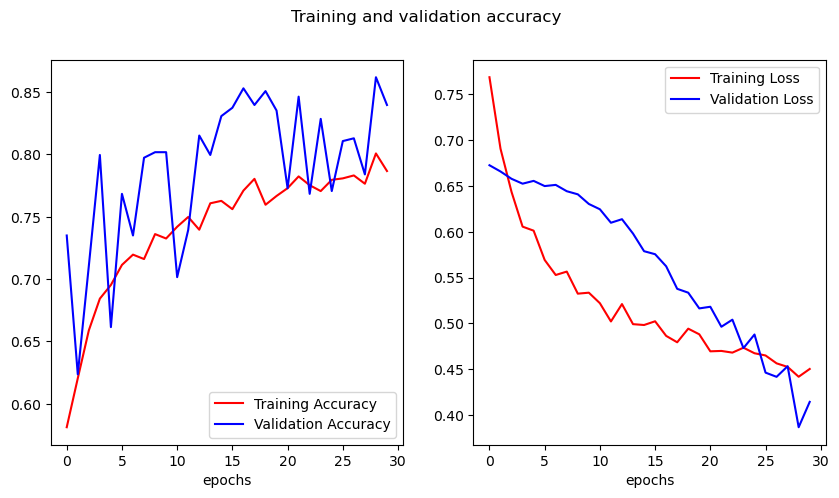

In [43]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

In [45]:
# Evaluasi model pada data validasi atau uji
val_loss, val_accuracy = model.evaluate(validation_dataset)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 526ms/step - accuracy: 0.8325 - loss: 0.4141
Validation Loss: 0.41449159383773804
Validation Accuracy: 0.839643657207489


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step


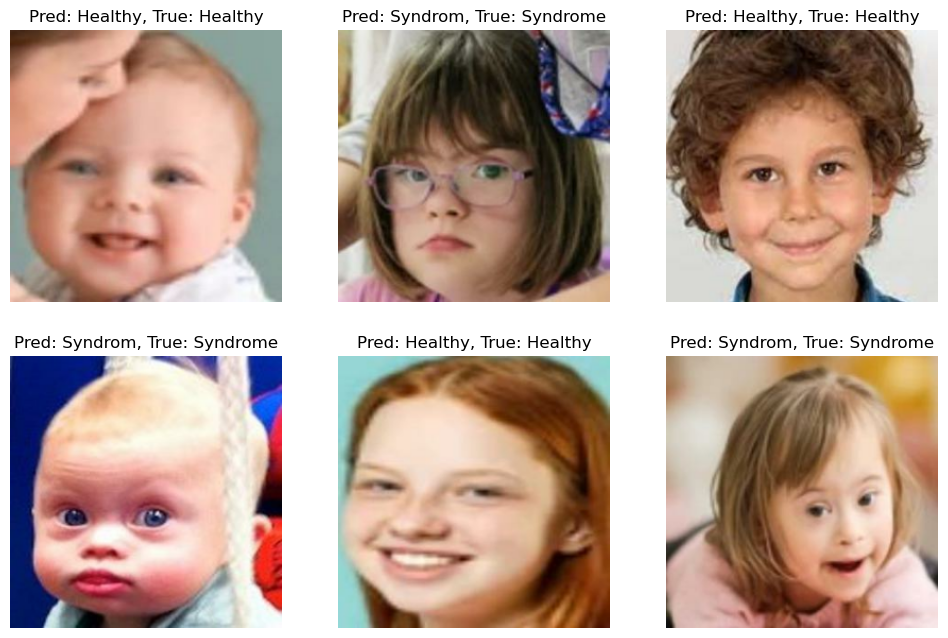

In [47]:
# Memvisualisasikan beberapa gambar dari test set dengan prediksi
for images, labels in validation_dataset.take(1):
    predictions = model.predict(images)
    plt.figure(figsize=(12, 12))
    for i in range(6):  # Menampilkan 9 gambar pertama
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = "Healthy" if predictions[i] > 0.5 else "Syndrom"
        true_label = "Syndrome" if labels[i] == 0 else "Healthy"
        plt.title(f"Pred: {pred_label}, True: {true_label}")
        plt.axis("off")
    plt.show()


In [49]:
def create_model_with_mobilenet():
    # Load the MobileNetV2 model pre-trained on ImageNet
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(256, 256, 3),  # adjust the input shape to match dataset.
        include_top=False,
        weights='imagenet'
    )
    
    # Freeze the base model's layers
    base_model.trainable = False
    
    # Create the model
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(256, 256, 3)), # adjust the input shape to match dataset.
        tf.keras.layers.Rescaling(1.0 / 255),
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

In [51]:
# Create the MobileNet-based model
model = create_model_with_mobilenet()

# Train the model
history = model.fit(
    training_dataset,
    epochs=10,
    validation_data=validation_dataset,
    callbacks=[EarlyStoppingCallback()]
)


C:\Users\ASUS\AppData\Local\Temp\ipykernel_13260\2323068323.py:3: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5125 - loss: 0.7783 - val_accuracy: 0.7283 - val_loss: 0.6069
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6257 - loss: 0.6533 - val_accuracy: 0.7617 - val_loss: 0.5545
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6753 - loss: 0.5987 - val_accuracy: 0.7773 - val_loss: 0.5204
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.6946 - loss: 0.5582 - val_accuracy: 0.7951 - val_loss: 0.4941
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7449 - loss: 0.5274 - val_accuracy: 0.7951 - val_loss: 0.4747
Epoch 6/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.7459 - loss: 0.5190 - val_accuracy: 0.7996 - val_loss: 0.4630
Epoch 7/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.7705 - loss: 0.4842 - val_accuracy: 0.8062 - val_loss: 0.4457
Epoch 8/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 2s/step - accuracy: 0.7835 

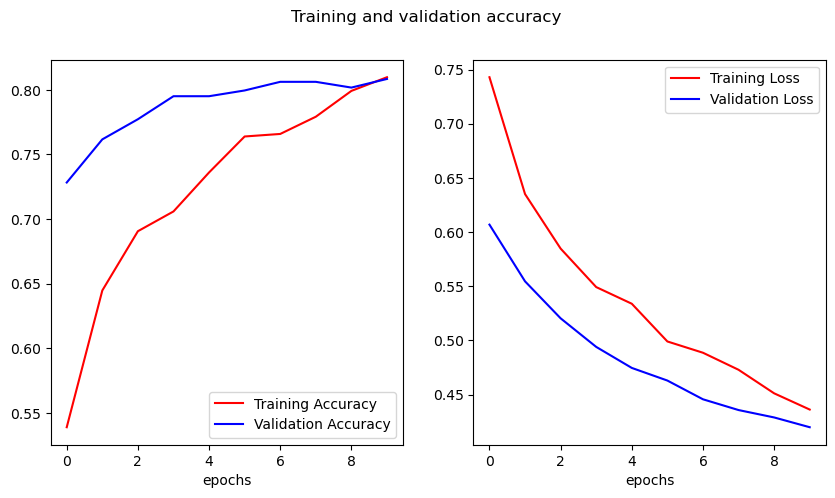

In [53]:
# Get training and validation accuracies
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.suptitle('Training and validation accuracy')

for i, (data, label) in enumerate(zip([(acc, val_acc), (loss, val_loss)], ["Accuracy", "Loss"])):
    ax[i].plot(epochs, data[0], 'r', label="Training " + label)
    ax[i].plot(epochs, data[1], 'b', label="Validation " + label)
    ax[i].legend()
    ax[i].set_xlabel('epochs')

plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step


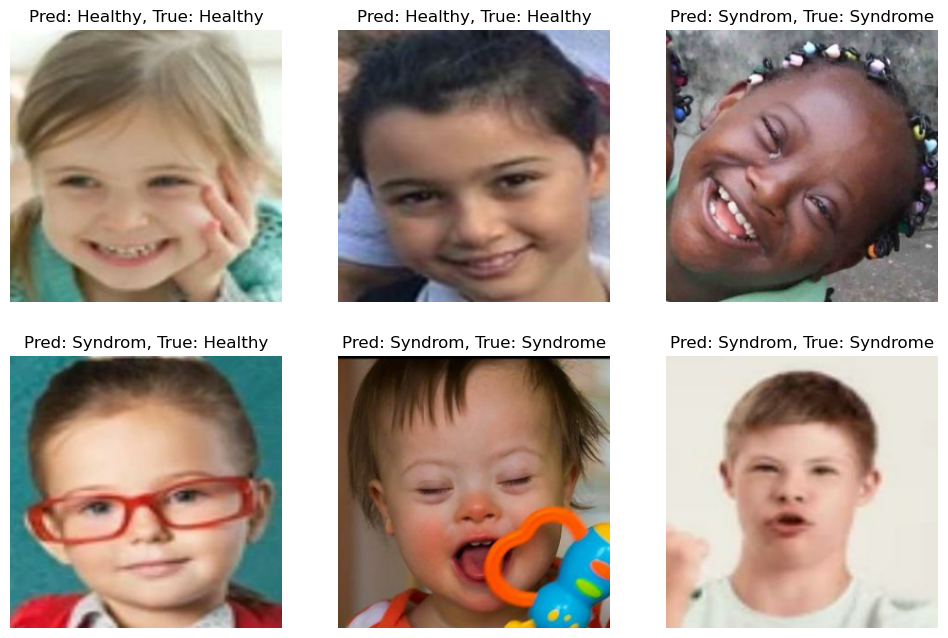

In [55]:
# Memvisualisasikan beberapa gambar dari test set dengan prediksi
for images, labels in validation_dataset.take(1):
    predictions = model.predict(images)
    plt.figure(figsize=(12, 12))
    for i in range(6):  # Menampilkan 9 gambar pertama
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        pred_label = "Healthy" if predictions[i] > 0.5 else "Syndrom"
        true_label = "Syndrome" if labels[i] == 0 else "Healthy"
        plt.title(f"Pred: {pred_label}, True: {true_label}")
        plt.axis("off")
    plt.show()


In [59]:
# -----------------------------
# Simpan Model
MODEL_PATH = os.path.join(BASE_DIR, 'tflearn_downsyndrome_classification_model.h5')
model.save(MODEL_PATH)
print(f"Model saved successfully at {MODEL_PATH}!")

Model saved successfully at C:\Users\ASUS\Documents\ML CNN (Bangkit)\tflearn_downsyndrome_classification_model.h5!
